In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import numpy as np
from scipy.constants import physical_constants
import copy

In [3]:
def traj_coord(traj,dx,dy):
    X=[]
    Y=[]
    Xmax=-np.inf
    Ymax=-np.inf
    for i in range(len(traj)):
        x,y=coordinates(traj[i],dx,dy)
        xmax=max(x) 
        Xmax=xmax if xmax>Xmax else Xmax
        ymax=max(y) 
        Ymax=ymax if ymax>Ymax else Ymax
        X.append(x.copy())
        Y.append(y.copy())
    xlim=(-10,Xmax+10)
    ylim=(-20,Ymax+20)
    return X,Y,xlim,ylim

In [4]:
def get_ani(traj,dx,dy,frames=None):#(xdata,ydata,xlim,ylim,frames=None):
    
    xdata,ydata,xlim,ylim=traj_coord(traj,dx,dy)
    if frames is None:
        frames=len(ydata)
        
    fig, ax = plt.subplots()
    ax.set_xlim((xlim))
    ax.set_ylim((ylim))
    l, = ax.plot([],[],'o')
    
    def animate(i):
        l.set_data(xdata[i],ydata[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames)
    plt.close()
    
    return ani

In [5]:
def traj_stat(traj):
    nouter=len(traj)
    nalone=np.zeros(nouter)
    ndimer=np.zeros(nouter)
    ncluster=np.zeros(nouter)
    #scluster=[list() for i in range(nouter)] 

    for i in range(nouter):
        reduced=copy.deepcopy(traj[i])
        while len(reduced)>0:
            cluster=allconnected(reduced,0,nx,ny) 
            members=len(cluster)
            if   members==1:
                nalone[i]+=1
            elif members ==2:
                ndimer[i]+=1
            else:
                ncluster[i]+=1
                #scluster[i].append(members)

            #### I will not check molecules already found in a cluster
            for c in cluster:
                reduced.remove(c)
    return nalone, ndimer, ncluster

## Import monte_carlo.py functions

> coordinates <br>
neighbors <br>
allconnected 

In [6]:
from monte_carlo import *

## Tasks

1. Estimate the dimer binding energy as $de=k_BT \ ln(n_0/n_{exp})$ where $k_B$ is the Boltzmann's constant, T is the simulation (and experiment) temperature, $n_0$ is the concentration of dimers in the case of zero interaction and $n_{exp}$ is the concentration of dimers found in the experiment.


2. Repeat the simulation using as $dE$ your estimate. What do you get?


3. Repeat the simulation with coverage 0.1 and $de=-0.02$ then $de=-0.1$ Describe what you obtain. Now try $coverage=0.1, T=400, dE=-0.1$ Comment the result

## Monte Carlo parameters



In [51]:
de=-0.008 #(for task 1, no interaction)
T=200
kb=physical_constants['Boltzmann constant in eV/K'][0]
beta =1.0/(kb*T)
nouter=100
ninner=10

## Honeycomb lattice define

In [52]:
sr3=np.sqrt(3.0)
nx=50
ny=nx/2
dx=10.02
dy=dx*sr3

<img src="hex_convention.png" width=500 height=500>

The figure illustrates the hexagonal lattice. The blue dot (1) is positioned at site $si=0$ of cell [$xi$,$yi$]=[$4,2$] and the blue dot (5) at site $si=1$ of the same cell.

## #Molecules

In [53]:
coverage= 0.02#(look in paper lowest coverage)
nmolecules=int(nx*nx*coverage)

## Run ...
This Monte Carlo implemets an **outer** and an **inner** cicle, i.e. for each outer step, an inner loop is runned. <br> Statistics for the system of molecules are sampled for each outer step, by performing statistical averages over the configurations obtained from the inner circle.

In [54]:
molecules=[]
i=0

#### Create initial geometry
while i < nmolecules :
    xi=np.random.randint(0,nx)
    yi=np.random.randint(0,ny)
    si=np.random.randint(0,2)
    newmolecule=[xi,yi,si]
    if  newmolecule not in molecules:
        molecules.append(newmolecule)
        i=i+1
#### END Create initial geometry

#### Initial energy
totene=0.0
for m in range(nmolecules):
    n,l =neighbors(molecules,m,nx,ny)
    totene+=n*de
totene/=2

nacc=0  # acceptance rate
nrej=0  # rejection rate
avgene=np.zeros(nouter) # average energy
traj=[] # trajectory of system of molecules per outer step

#### outer loop
for i in range(nouter):
    
    maxinner=ninner*20
    nsteps=0
    j=0
    while (j<ninner):
        '''
            TODO
            
            1. Select a molecule from the initial geometry, molecules=[...].
                
            2. Pick at random a new position.
            
            3. Check that the new position is not already occupied
            
            4. Compute the energy of the new configuration: 
            hint: e=(de*n), where n is the number of neighbors returned by 
            the function n,l=neighbor(molecules,selected,nx,ny).  
            
            5. Decide whether to accept or not the move.
            hint: deltae=enew-eold p<exp(-beta*deltae)
            
            6. Update the total energy, totene, and geometry, molecules, 
            if necessary.
            
        '''
        selected = np.random.randint(0, nmolecules)
        
        while True:
            xi=np.random.randint(0,nx)
            yi=np.random.randint(0,ny)
            si=np.random.randint(0,2)
            newpos=[xi,yi,si]
            if newpos not in molecules:
                break
                
        eold = de * neighbors(molecules, selected, nx, ny)[0]
        
        oldpos = molecules[selected]
        molecules[selected] = newpos.copy()
        
        enew = de * neighbors(molecules, selected, nx, ny)[0]
        
        deltae = enew - eold
        
        if np.random.random() < np.exp(-beta*deltae):
            totene += deltae
            nacc += 1
            j += 1
        else:
            molecules[selected] = oldpos.copy()
            nrej += 1
        
        avgene[i] += totene
        
        
        
        
        
        
        nsteps+=1
        if nsteps==maxinner: 
            print('coverage too big')
            exit()

    #### STATISTICS and LOG
    avgene[i]/=ninner
    traj.append(copy.deepcopy(molecules))

## Count #alone,#dimer,#cluster

> #alone = unpaired molecule && not in any cluster <br> #dimer= number of dimers <br> #cluster= number of clusters

In [55]:
nalone, ndimer, ncluster = traj_stat(traj)

## Check convergence

1. Visually check that the energy **and** the #dimer converge. 
2. If **not** converged goto **Monte Carlo parameters**, incerase *nouter* and **Run ..** again the simulation

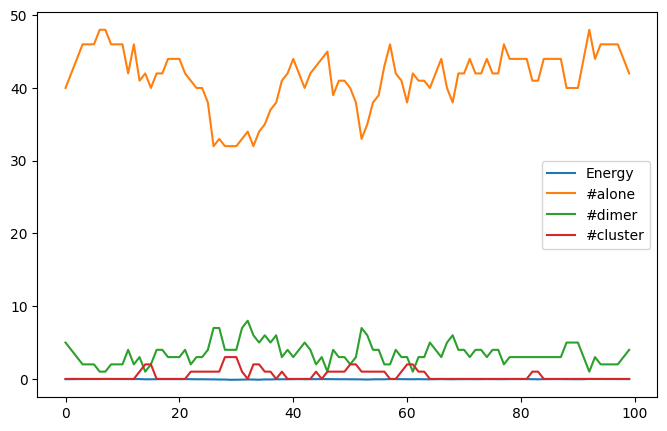

In [56]:
plt.figure(figsize=(8,5))
plt.plot(avgene,label='Energy')
plt.plot(nalone,label='#alone')
plt.plot(ndimer,label='#dimer')
plt.plot(ncluster,label='#cluster')
plt.legend()

## Create animation

Visualize the trajectory.

In [15]:
ani = get_ani(traj,dx,dy)

In [16]:
HTML(ani.to_jshtml())

In [57]:
np.mean(ndimer)

3.48

## Task 1 
- $de = k_BT \ln(n_0 / n_{exp})$, $n_0$ = 3.21 * 2 / 50 = 0.128, $n_{exp}$ = 0.3 $\rightarrow de = -0.0147 $eV

## Task 2
- get $-0.008$eV,  not really close to exp

## Task 3
- increasing T will increase propablity of separating, decreasing de and increasing coverage will increase cluster size